In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import csv
from collections import Counter
from math import sqrt
import os

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Progress bar for loops
from tqdm.notebook import tqdm

# Additional NumPy function
from numpy import interp

if not os.path.exists("images"):
    os.mkdir("images")

In [2]:
speech = pd.read_csv('outliercorrected_pd_speech_features.csv',header=[0,1],index_col=0)
display(speech)

# make a list of columns that contain all features, that are not patient id, class and gender
column_list = list(speech.columns)
feature_columns  = column_list.copy()
feature_columns.remove(('Info','class'))
feature_columns.remove(('Info','gender'))
display(feature_columns)

Info Baseline Features                                                   \
    gender               PPE       DFA      RPDE   numPulses numPeriodsPulses   
ID                                                                              
0      1.0          0.823387  0.696370  0.567250  235.333333       234.333333   
1      0.0          0.422263  0.793993  0.592453  213.333333       211.000000   
2      1.0          0.801973  0.619967  0.520563  319.333333       318.333333   
3      0.0          0.828707  0.626097  0.537183  493.000000       492.000000   
4      0.0          0.831287  0.779397  0.726717  362.666667       361.666667   
..     ...               ...       ...       ...         ...              ...   
247    0.0          0.751703  0.651830  0.586847  326.000000       324.666667   
248    1.0          0.611750  0.688327  0.452343  356.666667       355.333333   
249    1.0          0.819857  0.788800  0.373520  339.666667       338.666667   
250    0.0          0.600530  0.569010  0.411987  402.333333       401.000000   
251    0.0          0.844917  0.745653  0.476707  353.666667       352.666667   

                                                                   ...  \
    meanPeriodPulses stdDevPeriodPulses locPctJitter locAbsJitter  ...   
ID                                                                 ...   
0           0.008220           0.000073     0.001963     0.000016  ...   
1           0.008884           0.001849     0.005790     0.000050  ...   
2           0.006041           0.000104     0.002217     0.000013  ...   
3           0.003913           0.000042     0.000757     0.000003  ...   
4           0.005622           0.002023     0.003593     0.000021  ...   
..               ...                ...          ...          ...  ...   
247         0.005911           0.000251     0.003193     0.000019  ...   
248         0.005410           0.000964     0.002467     0.000014  ...   
249         0.005684           0.000042     0.000800     0.000005  ...   
250         0.004775           0.000103     0.000983     0.000005  ...   
251         0.005475           0.000065     0.000820     0.000005  ...   

                TQWT Features                            \
    tqwt_kurtosisValue_dec_28 tqwt_kurtosisValue_dec_29   
ID                                                        
0                    1.561733                  2.862000   
1                    4.918567                  4.827133   
2                   41.129400                 31.201933   
3                    1.677633                  1.908400   
4                    4.104600                  4.285233   
..                        ...                       ...   
247                 19.298667                 15.072200   
248                  4.448533                  3.180933   
249                 90.482767                 65.641367   
250                  2.674667                  2.714200   
251                 44.571367                 26.370167   

                                                         \
    tqwt_kurtosisValue_dec_30 tqwt_kurtosisValue_dec_31   
ID                                                        
0                   12.293333                  9.717500   
1                    6.117633                  8.599667   
2                   14.584467                  5.446800   
3                    2.842167                  3.493867   
4                    2.953200                  2.799933   
..                        ...                       ...   
247                 13.479700                 14.877933   
248                  2.880233                  2.805067   
249                 29.098533                  8.966500   
250                  2.706000                  2.637700   
251                 14.782567                  4.455833   

                                                         \
    tqwt_kurtosisValue_dec_32 tqwt_kurtosisValue_dec_33   
ID                                                        
0  

[('Baseline Features', 'PPE'),
 ('Baseline Features', 'DFA'),
 ('Baseline Features', 'RPDE'),
 ('Baseline Features', 'numPulses'),
 ('Baseline Features', 'numPeriodsPulses'),
 ('Baseline Features', 'meanPeriodPulses'),
 ('Baseline Features', 'stdDevPeriodPulses'),
 ('Baseline Features', 'locPctJitter'),
 ('Baseline Features', 'locAbsJitter'),
 ('Baseline Features', 'rapJitter'),
 ('Baseline Features', 'ppq5Jitter'),
 ('Baseline Features', 'ddpJitter'),
 ('Baseline Features', 'locShimmer'),
 ('Baseline Features', 'locDbShimmer'),
 ('Baseline Features', 'apq3Shimmer'),
 ('Baseline Features', 'apq5Shimmer'),
 ('Baseline Features', 'apq11Shimmer'),
 ('Baseline Features', 'ddaShimmer'),
 ('Baseline Features', 'meanAutoCorrHarmonicity'),
 ('Baseline Features', 'meanNoiseToHarmHarmonicity'),
 ('Baseline Features', 'meanHarmToNoiseHarmonicity'),
 ('Intensity Parameters', 'minIntensity'),
 ('Intensity Parameters', 'maxIntensity'),
 ('Intensity Parameters', 'meanIntensity'),
 ('Formant Frequenci

In [3]:
def assign_dataset(index):
    if index in X_train.index:
        return 'train'
    elif index in X_val.index:
        return 'val'
    elif index in X_test.index:
        return 'test'
    else:
        return 'unknown'

In [4]:
def jackknife_feature_selection(X, y, n_features_to_select=10, n_estimators=100):
    # Convert multi-indexed DataFrame to numpy array
    X_train = X.values
    y_train = y.values if isinstance(y, pd.Series) else y
    
    feature_counts = Counter()
    
    # Jackknife procedure
    for i in range(X_train.shape[0]):
        # Remove one sample
        X_train_jackknife = np.delete(X_train, i, axis=0)
        y_train_jackknife = np.delete(y_train, i)
        
        # Rank features
        selector = SelectKBest(f_classif, k=n_features_to_select)
        selector.fit(X_train_jackknife, y_train_jackknife)
        
        # Get selected feature indices
        selected_features = selector.get_support(indices=True)
        
        # Update feature counts
        feature_counts.update(selected_features)
    
    # Get top features
    top_features = [feature for feature, count in feature_counts.most_common(n_features_to_select)]
    
    # Map feature indices back to column names
    feature_names = X.columns.tolist()
    selected_feature_names = [feature_names[i] for i in top_features]
    
    return selected_feature_names

def evaluate_feature_subset(X_train, X_test, y_train, y_test, feature_subset, n_estimators=100):
    # Select features from multi-indexed DataFrame
    X_subset = X_train[feature_subset]
    X_test_subset = X_test[feature_subset]
    
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    rf.fit(X_subset, y_train)
    
    accuracy = rf.score(X_test_subset, y_test)
    return accuracy

def feature_selection_and_evaluation(X_train, X_val, y_train, y_val, n_features_to_select, n_estimators):
    # Perform jackknife feature selection
    selected_features = jackknife_feature_selection(X_train, y_train, n_features_to_select=n_features_to_select, n_estimators=n_estimators)
    print("Selected features:", selected_features)

    # Evaluate the selected feature subset
    accuracy_selected = evaluate_feature_subset(X_train, X_val, y_train, y_val, selected_features, n_estimators=n_estimators)
    print(f"Accuracy with selected features: {accuracy_selected:.4f}")

    # Compare with using all features
    accuracy_all = evaluate_feature_subset(X_train, X_val, y_train, y_val, X_train.columns, n_estimators=n_estimators)
    print(f"Accuracy with all features: {accuracy_all:.4f}")

    # Create a summary DataFrame
    result_df = pd.DataFrame({
        'Number of Estimators': n_estimators,
        'Number of Selected Features': n_features_to_select,
        'Accuracy with Selected Features': accuracy_selected,
        'Accuracy with All Features': accuracy_all,
        'Selected Features': [selected_features]
    })

    return result_df

make train test split

In [6]:
gender = speech[('Info','gender')]
y = speech[('Info','class')]

X_train_val, X_test, y_train_val, y_test, gender_train, gender_test = train_test_split(
    speech[feature_columns], y, gender, test_size=0.2, random_state=42)

In [8]:
seed_list = range(1,101)
results_df = pd.DataFrame()
for random_state in tqdm(seed_list):
    print(random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=random_state)
    speech_temp = X_train_val.copy()
    speech_temp[('Info', 'dataset')] = speech_temp.index.map(assign_dataset)
    result_df = feature_selection_and_evaluation(X_train, X_val, y_train, y_val, int(sqrt(len(feature_columns))), 1000)
    result_df['random state'] = random_state
    results_df = pd.concat([results_df, result_df], axis=0)


feature_counts = Counter()
for feature in results_df['Selected Features'].values:
    feature_counts.update(feature)
top_features = [feature for feature, count in feature_counts.most_common(int(sqrt(len(feature_columns))))]
display(top_features)

  0%|          | 0/100 [00:00<?, ?it/s]

1
Selected features: [('Formant Frequencies', 'f1'), ('MFCC ', 'mean_MFCC_2nd_coef'), ('MFCC ', 'std_8th_delta_delta'), ('TQWT Features', 'tqwt_entropy_shannon_dec_12'), ('TQWT Features', 'tqwt_entropy_shannon_dec_13'), ('TQWT Features', 'tqwt_entropy_shannon_dec_15'), ('TQWT Features', 'tqwt_TKEO_mean_dec_12'), ('TQWT Features', 'tqwt_TKEO_mean_dec_16'), ('TQWT Features', 'tqwt_TKEO_std_dec_12'), ('TQWT Features', 'tqwt_TKEO_std_dec_13'), ('TQWT Features', 'tqwt_stdValue_dec_12'), ('TQWT Features', 'tqwt_stdValue_dec_13'), ('TQWT Features', 'tqwt_minValue_dec_12'), ('TQWT Features', 'tqwt_minValue_dec_13'), ('TQWT Features', 'tqwt_maxValue_dec_12'), ('TQWT Features', 'tqwt_maxValue_dec_13'), ('TQWT Features', 'tqwt_kurtosisValue_dec_26'), ('TQWT Features', 'tqwt_kurtosisValue_dec_27'), ('MFCC ', 'std_8th_delta'), ('TQWT Features', 'tqwt_entropy_shannon_dec_16'), ('TQWT Features', 'tqwt_stdValue_dec_15'), ('TQWT Features', 'tqwt_stdValue_dec_16'), ('TQWT Features', 'tqwt_maxValue_dec_1

[('MFCC ', 'std_8th_delta_delta'),
 ('TQWT Features', 'tqwt_kurtosisValue_dec_27'),
 ('MFCC ', 'mean_MFCC_2nd_coef'),
 ('TQWT Features', 'tqwt_kurtosisValue_dec_26'),
 ('MFCC ', 'std_8th_delta'),
 ('MFCC ', 'std_9th_delta_delta'),
 ('MFCC ', 'std_7th_delta_delta'),
 ('MFCC ', 'std_6th_delta_delta'),
 ('MFCC ', 'std_9th_delta'),
 ('MFCC ', 'std_7th_delta'),
 ('MFCC ', 'std_6th_delta'),
 ('TQWT Features', 'tqwt_minValue_dec_12'),
 ('MFCC ', 'std_11th_delta_delta'),
 ('TQWT Features', 'tqwt_stdValue_dec_12'),
 ('MFCC ', 'std_delta_delta_log_energy'),
 ('TQWT Features', 'tqwt_maxValue_dec_12'),
 ('MFCC ', 'std_11th_delta'),
 ('MFCC ', 'std_10th_delta_delta'),
 ('TQWT Features', 'tqwt_maxValue_dec_11'),
 ('TQWT Features', 'tqwt_stdValue_dec_11'),
 ('TQWT Features', 'tqwt_minValue_dec_13'),
 ('TQWT Features', 'tqwt_entropy_log_dec_12'),
 ('TQWT Features', 'tqwt_kurtosisValue_dec_28'),
 ('MFCC ', 'std_10th_delta'),
 ('TQWT Features', 'tqwt_entropy_shannon_dec_15'),
 ('MFCC ', 'std_12th_delta_

Overall accuracy: 0.843


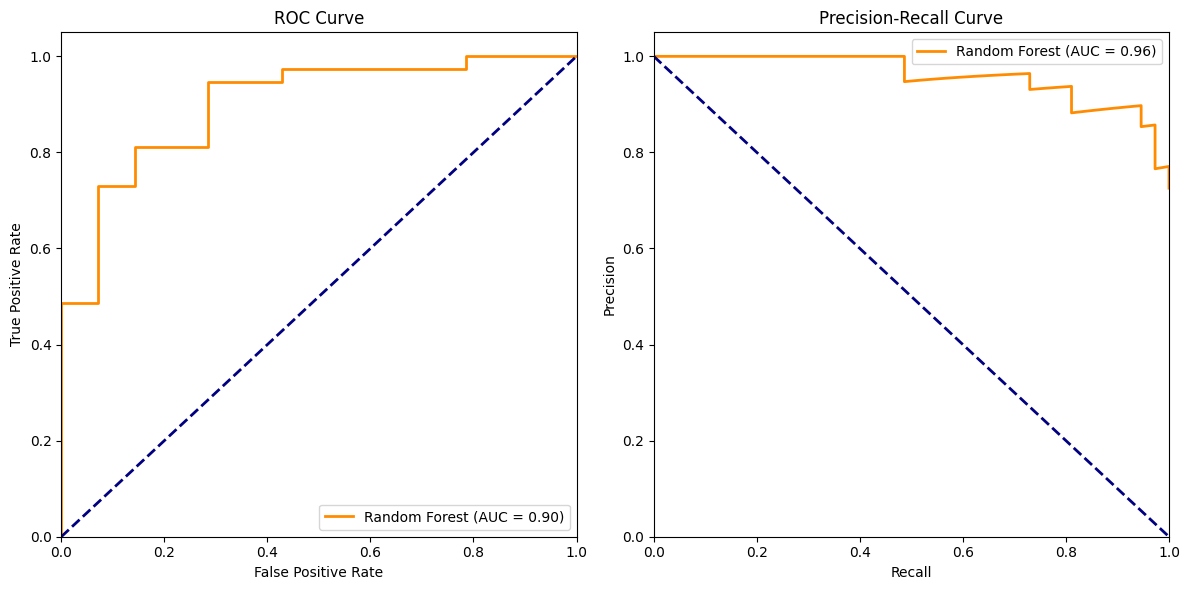

In [13]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
# Get probability predictions
rf.fit(X_train_val[top_features],y_train_val)

# Overall performance
y_pred = rf.predict(X_test[top_features])
print(f"Overall accuracy: {accuracy_score(y_test, y_pred):.3f}")
y_pred_proba = rf.predict_proba(X_test[top_features])

# Calculate ROC AUC score
auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
auc_pr = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Random Forest (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall curve
plt.subplot(122)
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Random Forest (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [84]:
from itertools import combinations
def get_columns_by_level(df, level_names, level=0):
    return df.columns[df.columns.get_level_values(level).isin(level_names)]

list_featuresets = list(pd.unique(speech.columns.get_level_values(0)))
list_featuresets.remove('Info')
combination_list = []
for i in range(len(list_featuresets)):
    combination_list_temp = list(combinations(list_featuresets,i))
    combination_list.extend(combination_list_temp)


for feature_sets in tqdm(combination_list, leave = False):
    if not feature_sets:
        continue
    rf_baseline = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
    selected_columns = get_columns_by_level(X_train_val,feature_sets)
    rf_baseline.fit(X_train_val[selected_columns],y_train_val)
    y_pred_proba = rf_baseline.predict_proba(X_test[selected_columns])
    # Calculate ROC AUC score
    auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])
    # Generate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
    auc_pr_test = auc(recall, precision)
    if auc_pr_test > auc_pr:
        print('-'.join(feature_sets),'\n', f'{auc_pr_test:.2f}, amount of features: {len(selected_columns)}' )

  0%|          | 0/255 [00:00<?, ?it/s]

Baseline Features-MFCC  0.96, amount of features: 105
Intensity Parameters-TQWT Features 0.96, amount of features: 435
Formant Frequencies-TQWT Features 0.96, amount of features: 436
Bandwidth Parameters-MFCC  0.96, amount of features: 88
Vocal Fold-TQWT Features 0.96, amount of features: 454
MFCC -TQWT Features 0.98, amount of features: 516
Baseline Features-Intensity Parameters-MFCC  0.96, amount of features: 108
Baseline Features-Formant Frequencies-MFCC  0.96, amount of features: 109
Baseline Features-Bandwidth Parameters-MFCC  0.96, amount of features: 109
Baseline Features-Bandwidth Parameters-TQWT Features 0.96, amount of features: 457
Baseline Features-MFCC -TQWT Features 0.98, amount of features: 537
Baseline Features-Wavelet Features-TQWT Features 0.96, amount of features: 635
Intensity Parameters-Formant Frequencies-TQWT Features 0.96, amount of features: 439
Intensity Parameters-Bandwidth Parameters-MFCC  0.97, amount of features: 91
Intensity Parameters-Bandwidth Parameter


sensitivity analysis

0 accuracy: 0.862
1 accuracy: 0.818


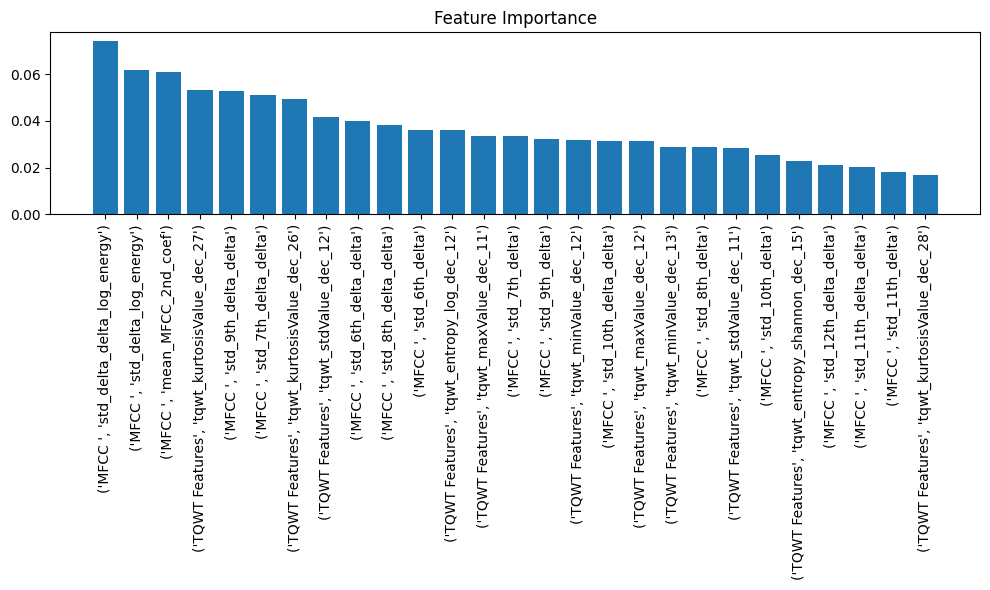

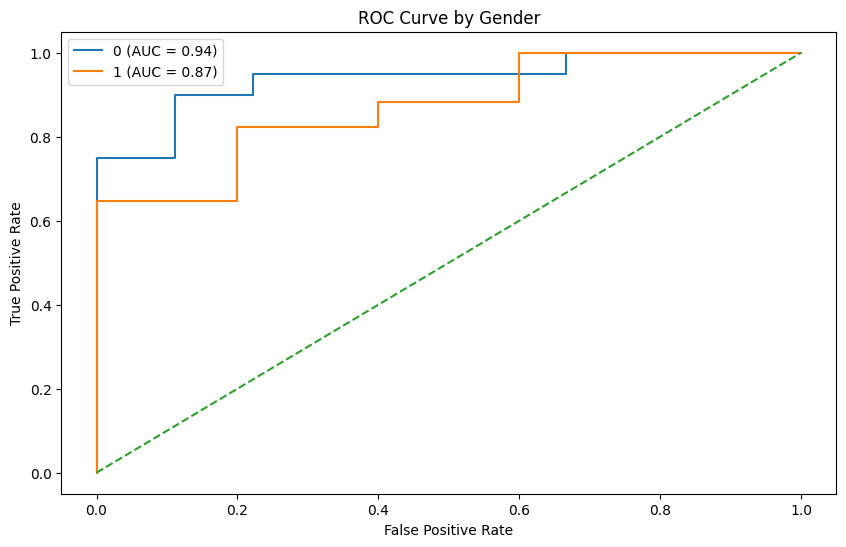

InvalidIndexError: slice(None, None, None)

In [24]:
X_test = X_test[top_features]
# Gender-specific performance
for gender_label in [0, 1]:
    gender_mask = (gender_test == gender_label)
    y_gender = y_test[gender_mask]
    X_gender = X_test[gender_mask]
    y_pred_gender = rf.predict(X_gender)
    print(f"{gender_label} accuracy: {accuracy_score(y_gender, y_pred_gender):.3f}")

# Feature importance
importances = rf.feature_importances_
feature_importance = pd.DataFrame({'feature': top_features, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'].astype(str), feature_importance['importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# ROC curves for each gender
plt.figure(figsize=(10, 6))
for gender_label in [0, 1]:
    gender_mask = (gender_test == gender_label)
    y_gender = y_test[gender_mask]
    X_gender = X_test[gender_mask]
    y_pred_proba = rf.predict_proba(X_gender)[:, 1]
    fpr, tpr, _ = roc_curve(y_gender, y_pred_proba)
    auc = roc_auc_score(y_gender, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{gender_label} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Gender')
plt.legend()
plt.show()

# Sensitivity analysis
for feature in top_features:
    X_test_mod = X_test.copy()
    X_test_mod[:, top_features.index(feature)] = 0  # Set feature to 0
    y_pred_mod = rf.predict(X_test_mod)
    print(f"Accuracy without {feature}: {accuracy_score(y_test, y_pred_mod):.3f}")

In [20]:
feature_importance['feature'].astype(str)

14             ('MFCC ', 'std_delta_delta_log_energy')
26                   ('MFCC ', 'std_delta_log_energy')
2                      ('MFCC ', 'mean_MFCC_2nd_coef')
1       ('TQWT Features', 'tqwt_kurtosisValue_dec_27')
5                     ('MFCC ', 'std_9th_delta_delta')
6                     ('MFCC ', 'std_7th_delta_delta')
3       ('TQWT Features', 'tqwt_kurtosisValue_dec_26')
13           ('TQWT Features', 'tqwt_stdValue_dec_12')
7                     ('MFCC ', 'std_6th_delta_delta')
0                     ('MFCC ', 'std_8th_delta_delta')
10                          ('MFCC ', 'std_6th_delta')
21        ('TQWT Features', 'tqwt_entropy_log_dec_12')
18           ('TQWT Features', 'tqwt_maxValue_dec_11')
9                           ('MFCC ', 'std_7th_delta')
8                           ('MFCC ', 'std_9th_delta')
11           ('TQWT Features', 'tqwt_minValue_dec_12')
17                   ('MFCC ', 'std_10th_delta_delta')
15           ('TQWT Features', 'tqwt_maxValue_dec_12')
20        